In [1]:
import tensorflow as tf
import numpy as np
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import random 

2024-06-15 17:23:23.472545: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 17:23:23.498395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:23:23.498417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:23:23.499837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 17:23:23.505903: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


2024-06-15 17:23:28.857920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:23:28.878361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:23:28.878400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:23:28.879994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:23:28.880028: I external/local_xla/xla/stream_executor

Found 10 files belonging to 10 classes.


In [3]:
for n, label in noise_ds:
    print(np.shape(n))
    break

(1, 368640, 1)


In [4]:
new_noise_audios = []

# iteriamo nel dataset con gli audio rumorosi
for noise, label in noise_ds:
    # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
    noise = tf.reshape(noise, [-1])[600:16600]
    new_noise_audios.append(noise.numpy()) # convertiamo in array per poterli modificare
    
test_noise_audio = new_noise_audios[0].astype(np.float32)
print(np.shape(new_noise_audios))

(10, 16000)


In [5]:
print(len(new_noise_audios))

10


In [6]:
display(Audio(new_noise_audios[4], rate=16000))

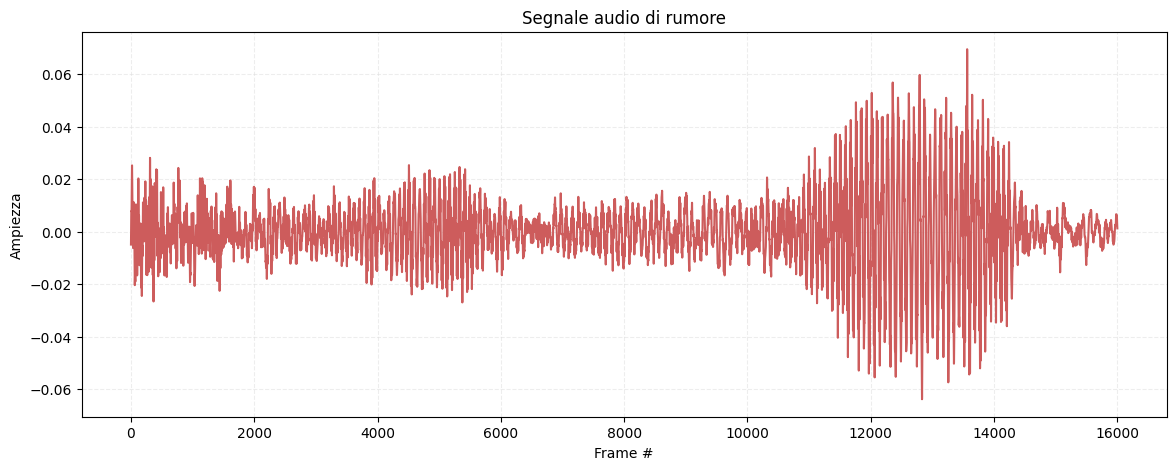

In [7]:
# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(new_noise_audios[4], color="indianred")
plt.title('Segnale audio di rumore')
plt.ylabel('Ampiezza')
plt.xlabel('Frame #')
plt.grid(True, color="gainsboro", linestyle="--", alpha=0.5)
plt.show()

In [8]:
mixed_dataset = []

counter = 0

train_ds = train_ds.unbatch()
labels_np = np.array([label.numpy() for _, label in train_ds])

for audio, label in train_ds:    
    audio = np.squeeze(audio, axis=-1)
    # Scegliamo in modo randomico un audio dalla lista ri
    
    noise_sample = random.choice(new_noise_audios)

    mixed_audio = audio + noise_sample # mo00ltiplichiamo per un valore costante molto piccoli cosi da ridurre il volume del rumore e far sentire meglio l'audio del comando
        
    # appendiamo alla lista mixed dataset
    mixed_dataset.append((mixed_audio, label))

# trasformiamo la lista mixed_dataset in un dataset da poter passare ai modelli
# mixed_dataset = tf.data.Dataset.from_tensor_slices(mixed_dataset)

nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuovo audio
nuov

In [9]:
print(mixed_dataset[0])

(array([-0.05227661, -0.05166626, -0.05105591, ...,  0.03009033,
        0.03155518,  0.03216553], dtype=float32), <tf.Tensor: shape=(), dtype=int32, numpy=27>)


In [10]:
audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in mixed_dataset]
labels = [label for _, label in mixed_dataset]

In [12]:
mixed_dataset = tf.data.Dataset.from_tensor_slices((audio_data, labels))

2024-06-15 17:24:24.668636: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 473.63MiB (rounded to 496640000)requested by op Pack
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-15 17:24:24.668685: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-06-15 17:24:24.668696: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 18, Chunks in use: 18. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 149B client-requested in use in bin.
2024-06-15 17:24:24.668701: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-06-15 17:24:24.668705: I external/local_

ResourceExhaustedError: {{function_node __wrapped__Pack_N_7760_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[7760,16000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: component_0

95] InUse at 728021b00 of size 64000 next 7460
2024-06-15 17:24:24.712936: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 728031500 of size 64000 next 7461
2024-06-15 17:24:24.712938: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 728040f00 of size 64000 next 7462
2024-06-15 17:24:24.712940: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 728050900 of size 64000 next 7463
2024-06-15 17:24:24.712942: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 728060300 of size 64000 next 7464
2024-06-15 17:24:24.712945: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 72806fd00 of size 64000 next 7465
2024-06-15 17:24:24.712947: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 72807f700 of size 64000 next 7466
2024-06-15 17:24:24.712949: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 72808f100 of size 64000 next 7467
2024-06-15 17:24:24.712951: I external/local_tsl/t

In [14]:
counter = 0

for audio, label in mixed_dataset:
    print(audio)
    print(label)
    display(Audio(audio, rate=16000))

    if counter == 2:
        break

    counter += 1
    break



[-0.05227661 -0.05166626 -0.05105591 ...  0.03009033  0.03155518
  0.03216553]
tf.Tensor(27, shape=(), dtype=int32)
